dt=168

In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [14]:
ds = xr.open_zarr('/swot/SUM01/spencer/run_1week_orechunked.zarr')

In [15]:
ds = ds.isel(niter=slice(1,338))
#ds = ds.drop_sel(niter=-20000)
#ds = ds.isel(z0=3)
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)
#ds = ds.dropna('npart')
#ds.niter.min()

In [16]:
mask_roundx = abs(ds.x.diff('time')).max('time')
mask_roundy = abs(ds.y.diff('time')).max('time')
ds = ds.where(mask_roundx<30)
ds = ds.where(mask_roundy<30)
#ds = ds.dropna('npart')
mask = ds['u'].where(np.isfinite(ds['u']),0).all('time')
ds=ds.where(mask>0,0)

In [17]:
dt=168

In [18]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(ds.u.drop('niter').isel(time=slice(168-dt,169+dt)),dim='time', window=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(ds.v.drop('niter').isel(time=slice(168-dt,169+dt)),dim='time', window=True).compute()#, detrend='linear'
ekehat = .5*(uhat2 + vhat2)

[                                        ] | 1% Completed |  2.5s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  5min 20.4s
[                                        ] | 0% Completed |  1.9s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  4min 41.3s


In [11]:
spec0 = int((ekehat['freq_time'].size-1)/2)

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

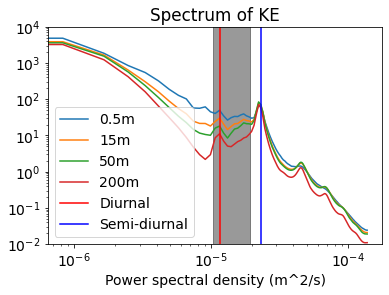

In [24]:
#Plot Lagrangian power spectrum
f1 = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-26.6*np.pi/180)
(ekehat.isel(z0=3).where(mask.isel(z0=3)>0)).mean(['x0','y0'])[spec0:].plot(label='0.5m')
(ekehat.isel(z0=2).where(mask.isel(z0=2)>0)).mean(['x0','y0'])[spec0:].plot(label='15m')
(ekehat.isel(z0=1).where(mask.isel(z0=1)>0)).mean(['x0','y0'])[spec0:].plot(label='50m')
(ekehat.isel(z0=0).where(mask.isel(z0=0)>0)).mean(['x0','y0'])[spec0:].plot(label='200m')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)
plt.xlabel('Power spectral density (m^2/s)')

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang.png')

In [77]:
dt=168
dt2=48
z_level=3
with ProgressBar():
    uhat_14day = xrft.dft(ds.u.drop('niter').isel(z0=z_level).isel(time=slice(168-dt,169+dt)),dim='time').compute()#, window=True
    uhat_2day = xrft.dft(ds.u.drop('niter').isel(z0=z_level).isel(time=slice(168-dt2,169+dt2)),dim='time', window=True).compute()

[##                                      ] | 5% Completed |  2.8s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 43.9s
[#                                       ] | 3% Completed |  2.7s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 35.9s


In [35]:
uhat_labeled14 = uhat_14day.assign_coords({"min_lat":ds.y.isel(z0=z_level).min('time')})
uhat_labeled2 = uhat_2day.assign_coords({"min_lat":ds.y.isel(z0=z_level).min('time')})
f_local = 2*2*np.pi/24/3600*np.sin(uhat_labeled14.min_lat*np.pi/180)
f_local = 2*2*np.pi/24/3600*np.sin(uhat_labeled2.min_lat*np.pi/180)
maxfreq_local = (-f_local/2/np.pi)*0.9

In [36]:
spec0_14 = int((uhat_labeled14['freq_time'].size-1)/2)
spec0_2 = int((uhat_labeled2['freq_time'].size-1)/2)

In [37]:
spec_cut14 = (uhat_labeled14.freq_time[spec0_14:]<maxfreq_local).argmin('freq_time').values+spec0_14
spec_cut2 = (uhat_labeled2.freq_time[spec0_2:]<maxfreq_local).argmin('freq_time').values+spec0_2

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [59]:
dfreq = ekehat.freq_time[spec0_14:].diff('freq_time')[1]
locfiltered_14 = (uhat_labeled14.where(abs(uhat_labeled14.freq_time)<maxfreq_local)*dfreq)
locfiltered_2 = (uhat_labeled2.where(abs(uhat_labeled14.freq_time)<maxfreq_local)*dfreq)

In [97]:
#ulocfiltered_14 = xrft.dft(locfiltered_14.where(np.isfinite(locfiltered_14),0),dim='freq_time', window=True).compute()
utransform_back = xrft.idft(uhat_14day.where(np.isfinite(locfiltered_14),0),dim='freq_time').compute()#, window=True

AttributeError: module 'xrft' has no attribute 'idft'

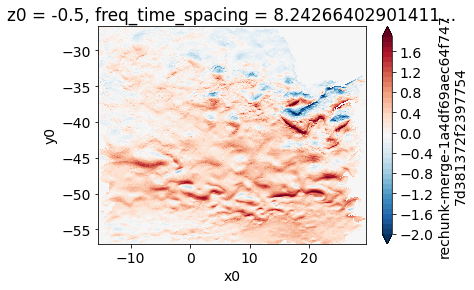

In [95]:
((utransform_back.sel(time=0).real)).plot(x='x0',levels=np.arange(-2,2,0.1))

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


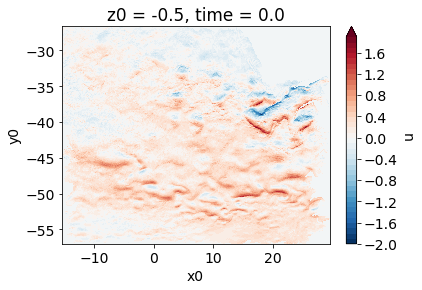

In [96]:
ds.u.drop('niter').isel(z0=z_level).sel(time=0).plot(x='x0',levels=np.arange(-2,2,0.1))

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


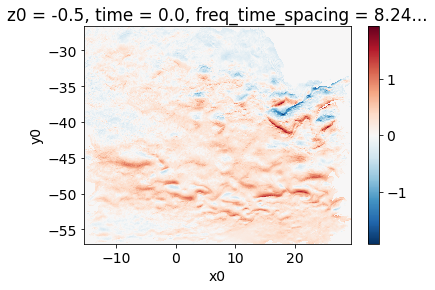

In [67]:
(ds.u.drop('niter').isel(z0=z_level).sel(time=0)-ulocfiltered_14.sel(time=0).real).plot(x='x0')

In [57]:
# Pause here as idft PR would be helpful and is near to being merged.

<xarray.DataArray 'min_lat' (x0: 2160, y0: 2160)>
dask.array<mul, shape=(2160, 2160), dtype=float64, chunksize=(180, 180), chunktype=numpy.ndarray>
Coordinates:
  * x0                 (x0) float64 -15.49 -15.47 -15.45 ... 29.45 29.47 29.49
  * y0                 (y0) float64 -57.0 -56.99 -56.98 ... -26.69 -26.68 -26.66
    z0                 float64 -0.5
    freq_time_spacing  float64 2.864e-06
    min_lat            (x0, y0) float64 dask.array<chunksize=(180, 180), meta=np.ndarray>

In [100]:
xrft.power_spectrum(ds.u.drop('niter').isel(z0=z_level).sel(time=0).chunk({'x0':-1}),dim=['x0'], window=True)

<xarray.DataArray 'rechunk-merge-ade9591a177ebcf9df42622243c4fc59' (freq_x0: 2160, y0: 2160)>
dask.array<truediv, shape=(2160, 2160), dtype=float64, chunksize=(2160, 180), chunktype=numpy.ndarray>
Coordinates:
  * y0               (y0) float64 -57.0 -56.99 -56.98 ... -26.69 -26.68 -26.66
    z0               float64 -0.5
    time             float64 0.0
  * freq_x0          (freq_x0) float64 -24.0 -23.98 -23.95 ... 23.93 23.95 23.98
    freq_x0_spacing  float64 0.02222